# **Team #1**

1492809 Marcela Reyes Garza

1877383 Kevin Alexis Osorio Rodríguez

1824834 Hiram Doroteo Leal Ríos

# **MÓDULOS UTILIZADOS**

Pandas: esta biblioteca ayuda a cargar el marco de datos en un formato de matriz 2D y tiene múltiples funciones para realizar tareas de análisis de una sola vez.

Numpy: las matrices Numpy son muy rápidas y pueden realizar grandes cálculos en muy poco tiempo.
Matplotlib: esta biblioteca se utiliza para dibujar visualizaciones.

Sklearn: este módulo contiene varias bibliotecas con funciones preimplementadas para realizar tareas desde el preprocesamiento de datos hasta el desarrollo y la evaluación de modelos.

OpenCV: esta es una biblioteca de código abierto enfocada principalmente en el procesamiento y manejo de imágenes.

Tensorflow: esta es una biblioteca de código abierto que se utiliza para el aprendizaje automático y la inteligencia artificial y proporciona una gama de funciones para lograr funcionalidades complejas con una sola línea de código.

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow import keras
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import load_img
from keras import layers

import warnings
warnings.filterwarnings('ignore')

# **VISUALIZACIÓN DE DATOS**

En esta sección, intentaremos comprender y visualizar algunas imágenes que se nos han proporcionado para construir el código para cada clase.

In [ ]:
pathTest = '/kaggle/input/skin-cancer-malignant-vs-benign/test'
classesTest = os.listdir(pathTest)
classesTest

['benign', 'malignant']

In [ ]:
pathTrain = '/kaggle/input/skin-cancer-malignant-vs-benign/train'
classesTrain = os.listdir(pathTrain)
classesTrain

['benign', 'malignant']

# **CLASES** 

El siguiente resultado puede variar cada vez que se ejecuta porque el código se implementó de tal manera que mostrará diferentes imágenes cada vez que vuelva a ejecutar el código.


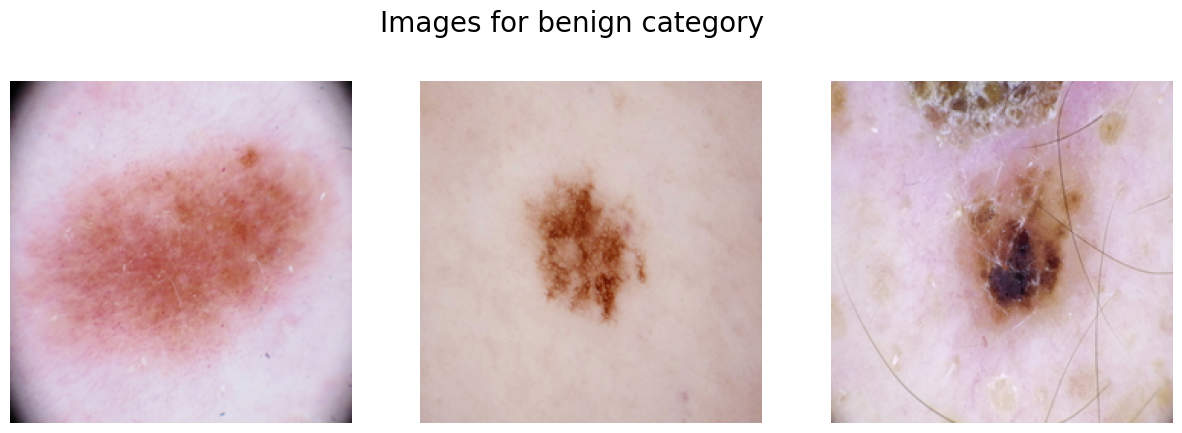

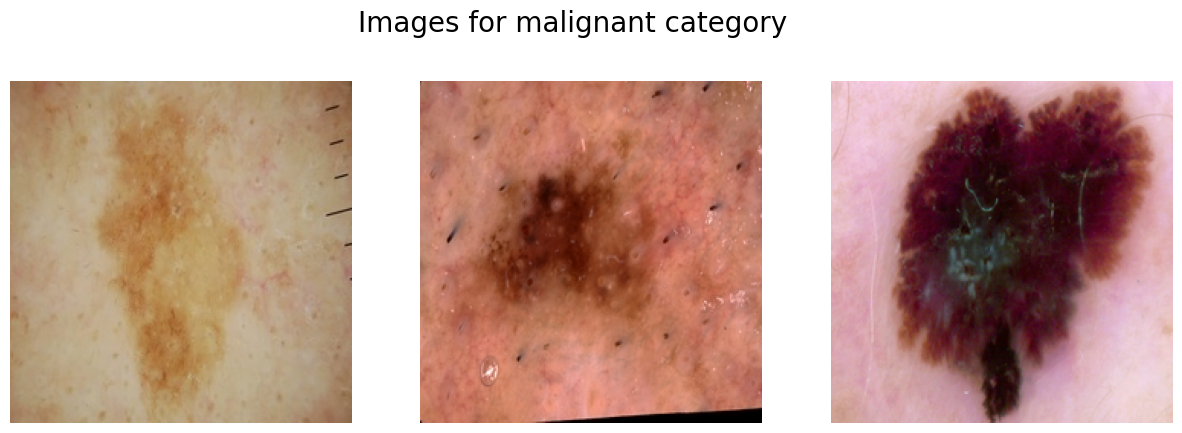

In [ ]:
pathTest = '/kaggle/input/skin-cancer-malignant-vs-benign/test'
 
for cat in classesTest:
    image_dir = f'{pathTest}/{cat}'
    images = os.listdir(image_dir)
 
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category', fontsize=20)
 
    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{pathTest}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

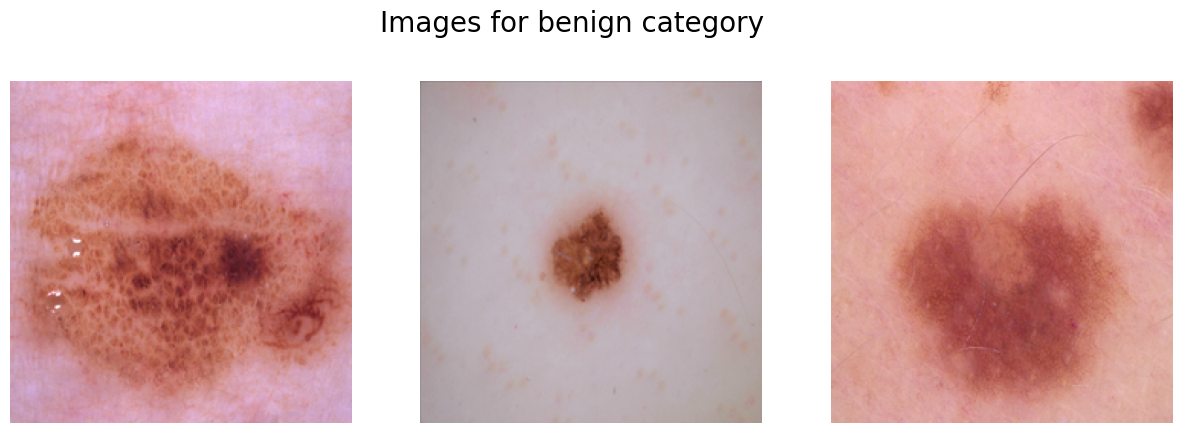

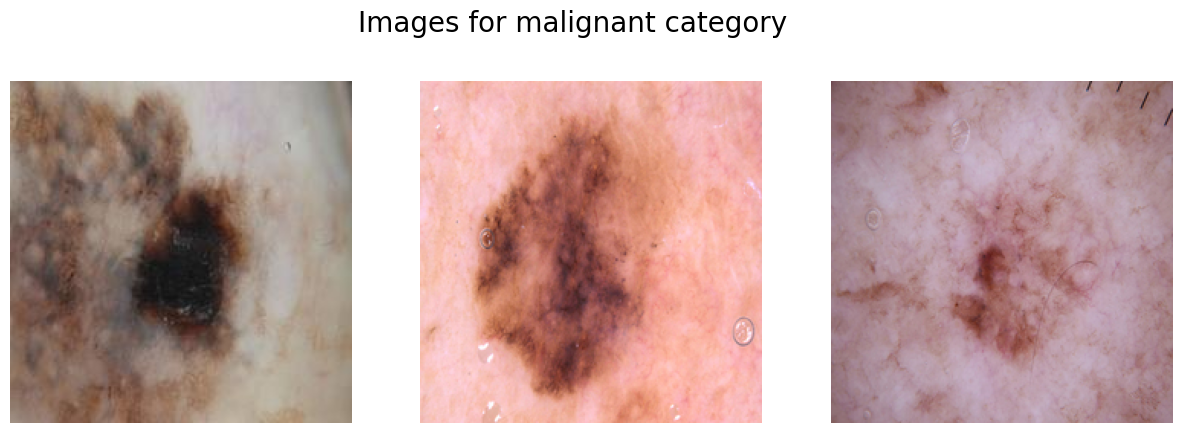

In [ ]:
pathTrain = '/kaggle/input/skin-cancer-malignant-vs-benign/train'
 
for cat in classesTrain:
    image_dir = f'{pathTrain}/{cat}'
    images = os.listdir(image_dir)
 
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category', fontsize=20)
 
    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{pathTrain}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [ ]:
pathImages = ['/kaggle/input/skin-cancer-malignant-vs-benign/data/train/benign',
             '/kaggle/input/skin-cancer-malignant-vs-benign/data/train/malignant']

def load_images(pathImages = pathImages, n=36):
    # Load the images from disk.
    images = []
    for i in range(len(pathImages)):
        images_ = [cv2.imread(pathImages[i]+'/'+path) for path in os.listdir(pathImages[i])[:int(n/4)]]
        images.append(images_)
    # Convert to a numpy array and return it.
    sample = np.asarray(images)
    return sample

# **FUNCIÓN PARA MOSTRAR IMÁGENES DE ENTRENAMIENTO DE EJEMPLO**

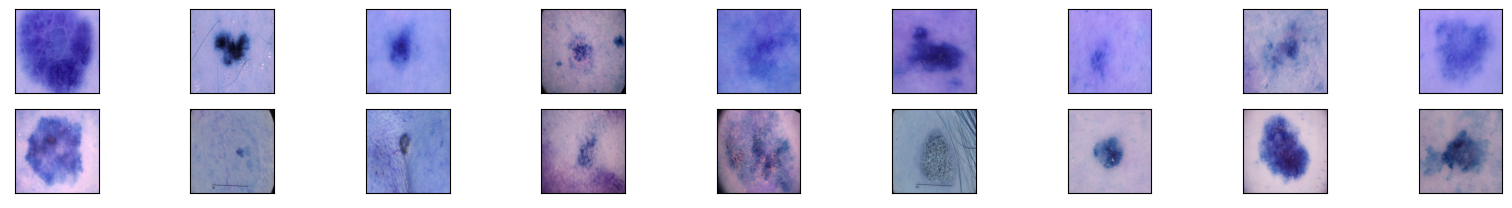

In [ ]:
sample = load_images()
fig = plt.figure(figsize=(20,5))
l = 1
shapes = []
for i in range(sample.shape[0]):
    for m in range(sample.shape[1]):
        ax = fig.add_subplot(4,9,m+l,xticks = [], yticks = [])
        ax.imshow(np.squeeze(sample[i,m]))
        shapes.append(sample[i,m].shape)
    l +=9

# **PREPROCESAMIENTO DE IMAGEN**

Debemos asegurarnos de que todas las imágenes tengan una escala similar, de lo contrario, tardará mucho más en converger.

In [ ]:
image_shape = (256,256,3)
N_CLASSES = 2
BATCH_SIZE = 1000

train_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
train_generator = train_datagen.flow_from_directory(pathTrain,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (256,256),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', rescale = 1.0/255.0)
test_generator = test_datagen.flow_from_directory(pathTest,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (256,256),
                                                   class_mode = 'categorical')

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


# **ARQUITECTURA DEL MODELO**

Implementaremos un modelo secuencial que contendrá las siguientes partes:

* Tres capas convolucionales seguidas de capas MaxPooling.
* La capa Flatten para aplanar la salida de la capa convolucional.
* Entonces tendremos dos capas completamente conectadas seguidas por la salida de la capa aplanada.
* Hemos incluido algunas capas de BatchNormalization para permitir un entrenamiento estable y rápido y una capa de abandono antes de la capa final para evitar cualquier posibilidad de sobreajuste.
* La capa final es la capa de salida que genera probabilidades blandas para las tres clases.

In [ ]:
model = keras.models.Sequential([
    layers.Conv2D(filters=64, #64
                  kernel_size=(6, 6),
                  activation='relu',
                  input_shape=(256,
                               256,
                               3),
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Conv2D(filters=64, #128
                  kernel_size=(4, 4), #///////////
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Conv2D(filters=128,#64
                  kernel_size=(2, 2),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Flatten(),
    layers.Dense(256, activation='relu'), #64
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'), #128
    layers.Dropout(0.3),#0.3
    layers.BatchNormalization(),
    layers.Dense(2, activation='softmax')#no mover
])

# **RESUMEN DE LA ARQUITECTURA DEL MODELO**

Podemos ver el cambio en la forma de la imagen de entrada después de pasar por diferentes capas. El modelo CNN que hemos desarrollado contiene alrededor de 33,6 millones de parámetros. Esta cantidad de parámetros y la complejidad del modelo es lo que ayuda a lograr un modelo de alto rendimiento que se utiliza en aplicaciones de la vida real.

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 256, 256, 64)      6976      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 128, 128, 64)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 64)      65600     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 128)       32896     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 32, 32, 128)     

# **CAMBIOS EN LA FORMA DE LA IMAGEN DE ENTRADA**

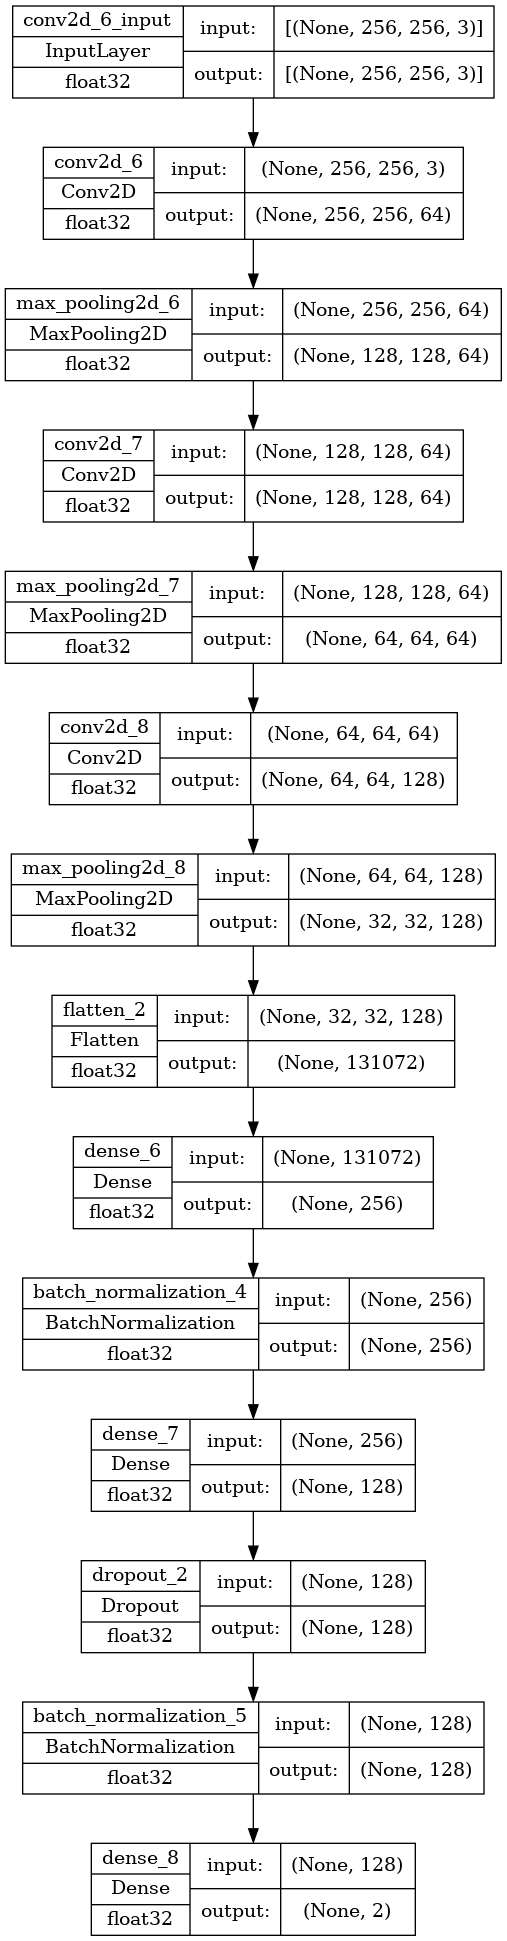

In [ ]:
tf.keras.utils.plot_model(
    model,
    show_shapes = True,
    show_dtype = True,
    #show_layer_activations = True
)

# **COMPILACIÓN**

Al compilar un modelo, proporcionamos estos tres parámetros esenciales:

* Optimizer: Este es el método que ayuda a optimizar la función de costo mediante el uso de descenso de gradiente.
* Loss: La función de pérdida por la cual monitoreamos si el modelo está mejorando con el entrenamiento o no.
* Metrics: Esto ayuda a evaluar el modelo al predecir el entrenamiento y los datos de validación.

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
    #optimizer = tf.keras.optimizers.Adam(0.1),
    #loss = 'mean_squared_error',
    #metrics = ['accuracy']
)

# **ENTRENAMIENTO, VALIDACIÓN Y PRUEBA DE DATAFRAME**

In [ ]:
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def create_df(tr_dir, ts_dir):
       
    # train dataframe
    files, classes = define_paths(tr_dir)
    train_df = define_df(files, classes)

    # test dataframe
    files, classes = define_paths(ts_dir)
    test_df = define_df(files, classes)
    return train_df, test_df

In [ ]:
def create_gens(train_df, test_df, batch_size):
    img_size = (256, 256)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    ts_length = len(test_df)
    test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size
    def scalar(img):
        return img
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)
    return train_gen, test_gen

In [ ]:
train_dir = '/kaggle/input/skin-cancer-malignant-vs-benign/train'
test_dir = '/kaggle/input/skin-cancer-malignant-vs-benign/test'

train_df, test_df = create_df(train_dir, test_dir)

train_gen, test_gen = create_gens(train_df, test_df, 74)

Found 2637 validated image filenames belonging to 2 classes.
Found 660 validated image filenames belonging to 2 classes.


# **COMPILACIÓN DEL MODELO**

In [ ]:

import tensorflow as tf
model.compile(optimizer="adam", loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

#early stopping function
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

# **ENTRENAMIENTO**

In [ ]:
#fit the model
histroy=model.fit(train_gen,
    validation_data = test_gen, 
    callbacks=[early],
    epochs = 5)

Epoch 1/5
36/36 [==============================] - 580s 16s/step - loss: 0.6703 - accuracy: 0.7019 - val_loss: 2.7721 - val_accuracy: 0.4606
Epoch 2/5
36/36 [==============================] - 579s 16s/step - loss: 0.5320 - accuracy: 0.7527 - val_loss: 2.4075 - val_accuracy: 0.5591
Epoch 3/5
36/36 [==============================] - 579s 16s/step - loss: 0.5019 - accuracy: 0.7725 - val_loss: 1.3593 - val_accuracy: 0.6470
Epoch 4/5
36/36 [==============================] - 579s 16s/step - loss: 0.4741 - accuracy: 0.7816 - val_loss: 1.1822 - val_accuracy: 0.5242
Epoch 5/5
36/36 [==============================] - 579s 16s/step - loss: 0.4258 - accuracy: 0.7933 - val_loss: 0.7368 - val_accuracy: 0.7818


# **VISUALIZACIÓN DEL ENTRENAMIENTO Y PRECISIÓN DE VALIDACIÓN CON CADA EPOCH**

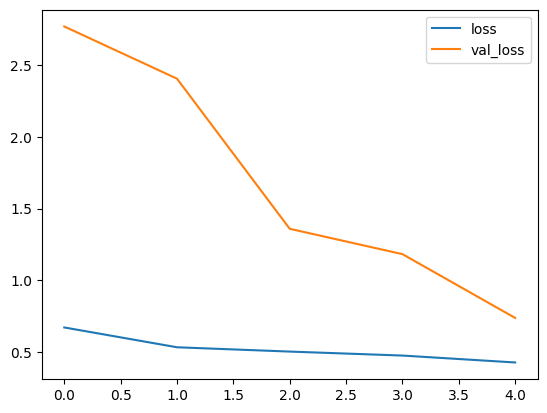

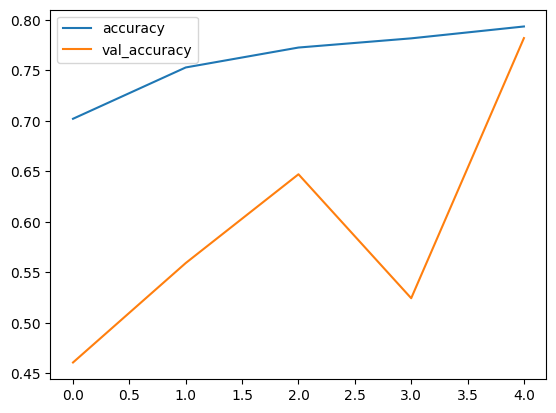

In [ ]:
history_df = pd.DataFrame(histroy.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

# **EVALUACIÓN DEL MODELO**

Para este propósito, primero predeciremos la clase de los datos de validación usando este modelo y luego compararemos la salida con las etiquetas verdaderas.

In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

[0 1 0 0 0 0 1 1 1 1 0 1 1 0 0 1 0 0 1 0 1 1 1 1 1 1 1 0 1 0 1 0 0 0 0 1 1
 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 1 1 1 1 0 1 1 0 0 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 1 0 0 1 0 1 0
 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 1 0 1 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0
 1 0 0 0 0 1 1 1 0 0 0 0 1 0 0 1 1 1 1 1 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0
 0 1 0 0 1 1 1 1 1 1 0 0 0 1 1 0 0 0 1 0 1 0 0 0 1 1 1 1 0 0 0 0 0 1 0 0 1
 1 0 0 0 0 0 1 1 0 0 0 0 1 1 1 0 1 0 0 0 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0
 1 0 1 1 1 0 1 0 0 1 0 1 0 0 1 1 1 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

# **MÉTRICAS DE CONFUSIÓN**

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
target_names = ['benign', 'malignant']

# **INFORME DE CLASIFICACIÓN PARA LOS DATOS DE VALIDACIÓN**

In [ ]:
print(classification_report(test_gen.classes, y_pred, target_names= target_names))

              precision    recall  f1-score   support

      benign       0.95      0.63      0.76       360
   malignant       0.68      0.96      0.80       300

    accuracy                           0.78       660
   macro avg       0.82      0.80      0.78       660
weighted avg       0.83      0.78      0.78       660



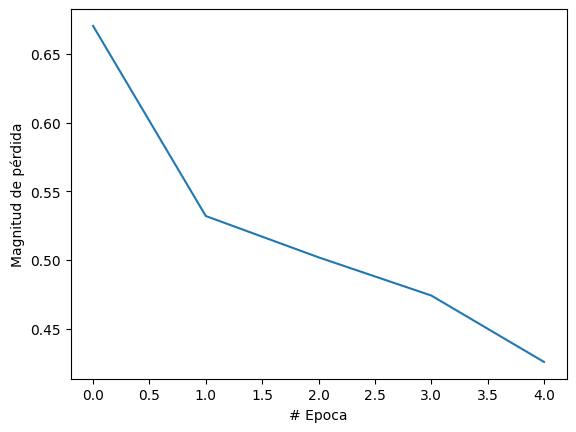

In [ ]:
import matplotlib.pyplot as plt
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de pérdida")
plt.plot(histroy.history["loss"])

# **Prueba #1 Benigno**

1/1 [==============================] - 0s 90ms/step
[[0.511695   0.48830497]]
Se sospecha que el lunar es: Benigno


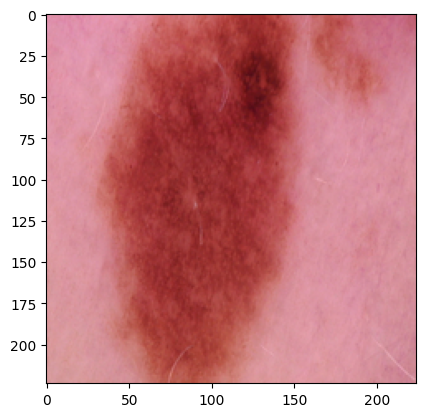

In [ ]:
import tensorflow as tf
image_path = '/kaggle/input/skin-cancer-malignant-vs-benign/test/benign/1003.jpg'
image_loaded = tf.keras.utils.load_img(image_path)
image_loaded
image = tf.keras.preprocessing.image.img_to_array(image_loaded)
image_resized = tf.image.resize(image_loaded, (256, 256))
image = np.expand_dims(image_resized,axis=0) 
ypred = model.predict(image)
print(ypred)
a=np.argmax(ypred,1)
if a==0:
      op="Benigno"
else:
      op="Maligno" 
plt.imshow(image_loaded)
print("Se sospecha que el lunar es: "+str(op))

# **Prueba #2 Maligno**

1/1 [==============================] - 0s 86ms/step
[[0.05395405 0.94604594]]
Se sospecha que el lunar es: Maligno


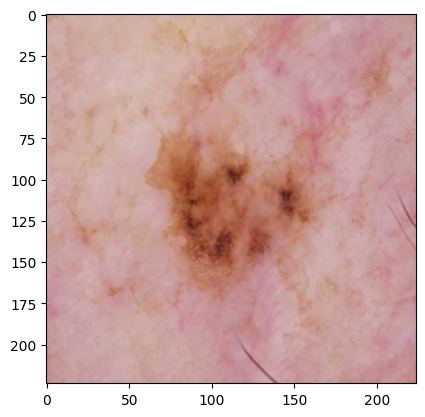

In [ ]:
import tensorflow as tf
image_path = '/kaggle/input/skin-cancer-malignant-vs-benign/test/malignant/1037.jpg'
image_loaded = tf.keras.utils.load_img(image_path)
image_loaded
image = tf.keras.preprocessing.image.img_to_array(image_loaded)
image_resized = tf.image.resize(image_loaded, (256, 256))
image = np.expand_dims(image_resized,axis=0) 
ypred = model.predict(image)
print(ypred)
a=np.argmax(ypred,1)
if a==0:
      op="Benigno"
else:
      op="Maligno" 
plt.imshow(image_loaded)
print("Se sospecha que el lunar es: "+str(op))

# **Prueba 3 Benigno**

1/1 [==============================] - 0s 99ms/step
[[0.9557193  0.04428078]]
Se sospecha que el lunar es: Benigno


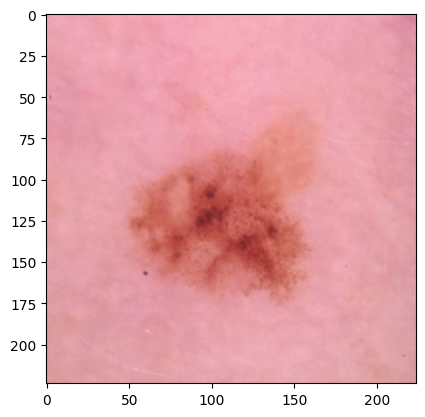

In [ ]:
import tensorflow as tf
image_path = '/kaggle/input/skin-cancer-malignant-vs-benign/test/benign/1125.jpg'
image_loaded = tf.keras.utils.load_img(image_path)
image_loaded
image = tf.keras.preprocessing.image.img_to_array(image_loaded)
image_resized = tf.image.resize(image_loaded, (256, 256))
image = np.expand_dims(image_resized,axis=0) 
ypred = model.predict(image)
print(ypred)
a=np.argmax(ypred,-1)
if a==0:
      op="Benigno"
else:
      op="Maligno" 
plt.imshow(image_loaded)
print("Se sospecha que el lunar es: "+str(op))

# **Prueba #4 Maligno**

1/1 [==============================] - 0s 82ms/step
[[0.12056848 0.87943155]]
Se sospecha que el lunar es: Maligno


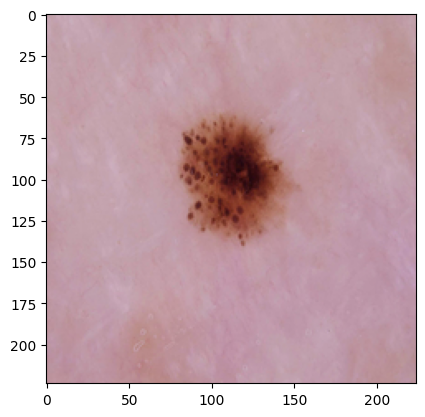

In [ ]:
import tensorflow as tf
image_path = '/kaggle/input/skin-cancer-malignant-vs-benign/test/malignant/1221.jpg'
image_loaded = tf.keras.utils.load_img(image_path)
image_loaded
image = tf.keras.preprocessing.image.img_to_array(image_loaded)
image_resized = tf.image.resize(image_loaded, (256, 256))
image = np.expand_dims(image_resized,axis=0) 
ypred = model.predict(image)
print(ypred)
a=np.argmax(ypred,-1)
if a==0:
      op="Benigno"
else:
      op="Maligno" 
plt.imshow(image_loaded)
print("Se sospecha que el lunar es: "+str(op))

# **Prueba #5 Benigno**

1/1 [==============================] - 0s 88ms/step
[[0.9765984  0.02340166]]
Se sospecha que el lunar es: Benigno


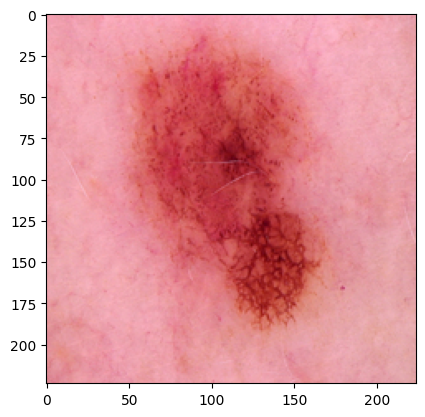

In [ ]:
import tensorflow as tf
image_path = '/kaggle/input/skin-cancer-malignant-vs-benign/test/benign/1261.jpg'
image_loaded = tf.keras.utils.load_img(image_path)
image_loaded
image = tf.keras.preprocessing.image.img_to_array(image_loaded)
image_resized = tf.image.resize(image_loaded, (256, 256))
image = np.expand_dims(image_resized,axis=0) 
ypred = model.predict(image)
print(ypred)
a=np.argmax(ypred,-1)
if a==0:
      op="Benigno"
else:
      op="Maligno" 
plt.imshow(image_loaded)
print("Se sospecha que el lunar es: "+str(op))

# **Prueba #6 Maligno**

1/1 [==============================] - 0s 82ms/step
[[6.7124073e-04 9.9932873e-01]]
Se sospecha que el lunar es: Maligno


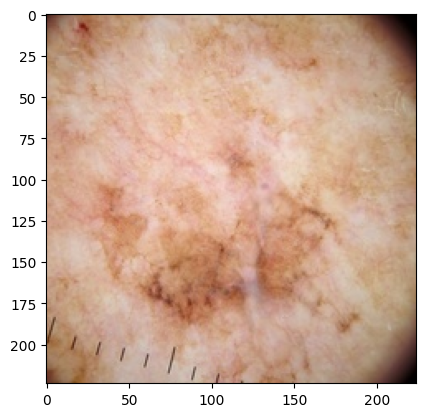

In [ ]:
import tensorflow as tf
image_path = '/kaggle/input/skin-cancer-malignant-vs-benign/test/malignant/1.jpg'
image_loaded = tf.keras.utils.load_img(image_path)
image_loaded
image = tf.keras.preprocessing.image.img_to_array(image_loaded)
image_resized = tf.image.resize(image_loaded, (256, 256))
image = np.expand_dims(image_resized,axis=0) 
ypred = model.predict(image)
print(ypred)
a=np.argmax(ypred,-1)
if a==0:
      op="Benigno"
else:
      op="Maligno" 
plt.imshow(image_loaded)
print("Se sospecha que el lunar es: "+str(op))

# **Prueba #7 Benigno**

1/1 [==============================] - 0s 82ms/step
[[0.8651953 0.1348047]]
Se sospecha que el lunar es: Benigno


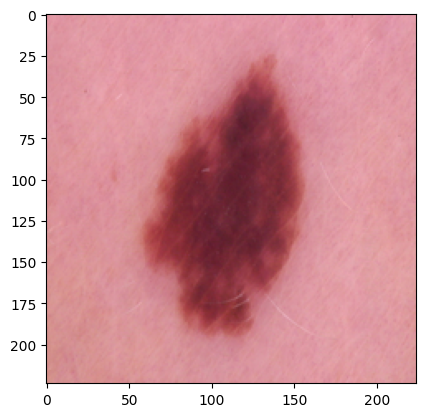

In [ ]:
import tensorflow as tf
image_path = '/kaggle/input/skin-cancer-malignant-vs-benign/test/benign/1029.jpg'
image_loaded = tf.keras.utils.load_img(image_path)
image_loaded
image = tf.keras.preprocessing.image.img_to_array(image_loaded)
image_resized = tf.image.resize(image_loaded, (256, 256))
image = np.expand_dims(image_resized,axis=0) 
ypred = model.predict(image)
print(ypred)
a=np.argmax(ypred,-1)
if a==0:
      op="Benigno"
else:
      op="Maligno" 
plt.imshow(image_loaded)
print("Se sospecha que el lunar es: "+str(op))

# **Prueba #8 Maligno**

1/1 [==============================] - 0s 84ms/step
[[0.00222765 0.9977723 ]]
Se sospecha que el lunar es: Maligno


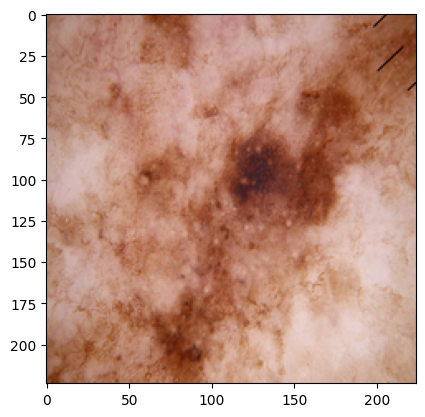

In [ ]:
import tensorflow as tf
image_path = '/kaggle/input/skin-cancer-malignant-vs-benign/test/malignant/1091.jpg'
image_loaded = tf.keras.utils.load_img(image_path)
image_loaded
image = tf.keras.preprocessing.image.img_to_array(image_loaded)
image_resized = tf.image.resize(image_loaded, (256, 256))
image = np.expand_dims(image_resized,axis=0) 
ypred = model.predict(image)
print(ypred)
a=np.argmax(ypred,-1)
if a==0:
      op="Benigno"
else:
      op="Maligno" 
plt.imshow(image_loaded)
print("Se sospecha que el lunar es: "+str(op))

# **Prueba #9 Benigno**

1/1 [==============================] - 0s 99ms/step
[[0.93332165 0.06667834]]
Se sospecha que el lunar es: Benigno


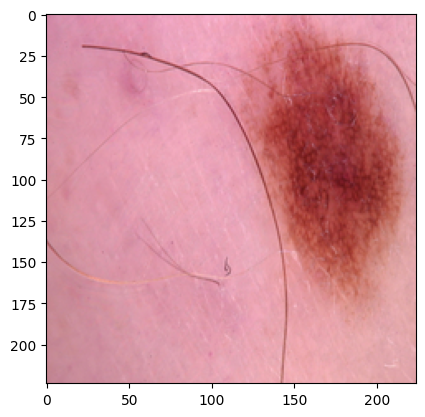

In [ ]:
import tensorflow as tf
image_path = '/kaggle/input/skin-cancer-malignant-vs-benign/test/benign/1023.jpg'
image_loaded = tf.keras.utils.load_img(image_path)
image_loaded
image = tf.keras.preprocessing.image.img_to_array(image_loaded)
image_resized = tf.image.resize(image_loaded, (256, 256))
image = np.expand_dims(image_resized,axis=0) 
ypred = model.predict(image)
print(ypred)
a=np.argmax(ypred,-1)
if a==0:
      op="Benigno"
else:
      op="Maligno" 
plt.imshow(image_loaded)
print("Se sospecha que el lunar es: "+str(op))

# **Prueba #10 Maligno**

1/1 [==============================] - 0s 82ms/step
[[0.03532069 0.9646793 ]]
Se sospecha que el lunar es: Maligno


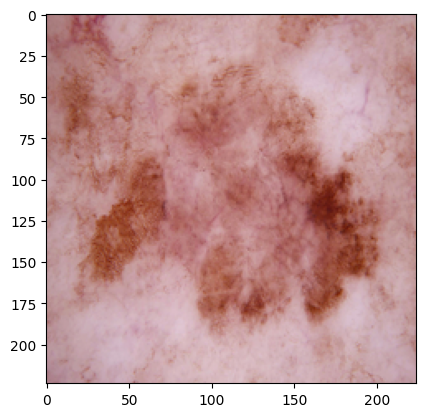

In [ ]:
import tensorflow as tf
image_path = '/kaggle/input/skin-cancer-malignant-vs-benign/test/malignant/1218.jpg'
image_loaded = tf.keras.utils.load_img(image_path)
image_loaded
image = tf.keras.preprocessing.image.img_to_array(image_loaded)
image_resized = tf.image.resize(image_loaded, (256, 256))
image = np.expand_dims(image_resized,axis=0) 
ypred = model.predict(image)
print(ypred)
a=np.argmax(ypred,-1)
if a==0:
      op="Benigno"
else: 
      op="Maligno" 
plt.imshow(image_loaded)
print("Se sospecha que el lunar es: "+str(op))